# CAP6615 - Spring 2022 -- PROGRAMMING ASSIGNMENT CNN+RNN for Time Series Prediction


### Programming Assignment 4 - CNN+RNN for Time Series Prediction

#### Group Members: 

* Aakash Naik
* Anurag Patil
* Hrishikesh Mahajan
* Kunal Dudhe
* Yash Shekhadar

**Spring Semester 2022**

**8 April 2022**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 1 - (3 pts)** Select S&P500 Dataset and Schiller P/E-10 Dataset from the following URLs, as you did for Programming Assignment #3 - and ensure that the datasets are synchronized (same sampling interval, identical start & end times):

https://www.nasdaq.com/market-activity/index/spx/historical

https://www.multpl.com/sitemap

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from numpy import savez_compressed
from PIL import Image, ImageOps

from sklearn.metrics import mean_absolute_error
import pickle as pkl
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, LeakyReLU,ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense, Convolution1D
from keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from scipy.signal import argrelextrema
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

In [ ]:
dParser = lambda x: pd.datetime.strptime(x, "%m/%d/%Y")
SPE_df = pd.read_csv("/content/drive/MyDrive/NNDM-4/PE_data.csv", index_col='Date' ,parse_dates=True, date_parser=dParser)
newData = pd.read_csv("/content/drive/MyDrive/NNDM-4/newData.csv", index_col='Date', parse_dates=True)
SPE_df.index = SPE_df.index + pd.offsets.MonthBegin(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [ ]:
SPE_df

,Value
Date,
2022-03-01,34.14
2022-02-01,37.54
2022-01-01,37.47
2021-12-01,38.66
2021-11-01,38.75
...,...
1900-05-01,18.41
1900-04-01,18.95
1900-03-01,18.78


In [ ]:
finalData = pd.merge(newData, SPE_df, how='left', on='Date').fillna(method='bfill')

In [ ]:
finalData

,Price,Open,High,Low,Value
Date,,,,,
2022-03-11,4204.31,4279.50,4291.01,4200.49,34.14
2022-03-10,4259.52,4252.55,4268.28,4209.80,34.14
2022-03-09,4277.88,4223.10,4299.40,4223.10,34.14
2022-03-08,4170.62,4202.66,4276.94,4157.87,34.14
2022-03-07,4201.09,4327.01,4327.01,4199.85,34.14
...,...,...,...,...,...
1980-01-07,106.80,106.80,107.80,105.80,8.85
1980-01-04,106.50,106.50,107.10,105.10,8.85
1980-01-03,105.20,105.20,106.10,103.30,8.85


In [ ]:
finalData.columns = ["Price", "Open", "High", "Low", "PE"]

In [ ]:
def getData(start, end, freq, wpe, colName):
  if wpe:
    res = newData.loc[start:end, colName].groupby(pd.Grouper(freq='M')).mean()
    res['PE'] = pd.Series(SPE_df.loc[start:end, 'Value'])
  else:
    res = newData.loc[start:end, colName].groupby(pd.Grouper(freq=freq)).mean()
  return res

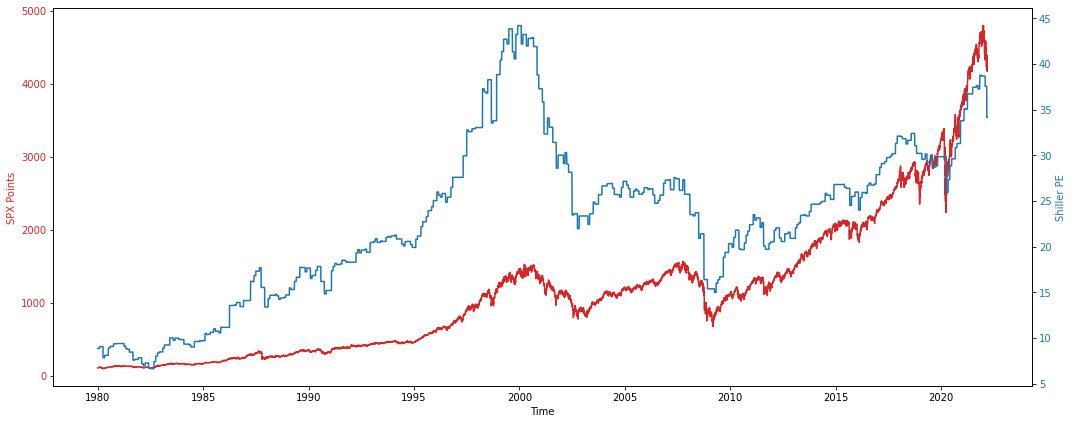

In [ ]:
t = finalData.index
data1 = finalData['Price']
data2 = finalData['PE']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('SPX Points', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Shiller PE', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
finalData = finalData[::-1]

**Step 2 - (6 pts)**  Develop and test/verify a correlation-based algorithm to correlate when the Schiller P/E ratio is very high (spikes upward significantly) and the S&P500 is also high (peaking or ready to peak).  Thus, your algorithm will act as a predictor of when to "sell" the S&P500 index (as if it were a stock or Exchange-Traded Fund (ETF)) by outputting a correlation coefficient in the range [-1, 1], where values in the range [0.9, 1] (or similar range) would be your "sell indicator".  This is an extension of the basic concept of Step 1 in Programming Assignment 2, and here is a URL that will help you get started with data:

https://www.longtermtrends.net/sp500-price-earnings-shiller-pe-ratio/

You will use this algorithm as a "reference" to determine how well the Schiller P/E predicts market bottoms or sell-offs.

**TO-DOCUMENT and VERIFY:**  Make an overlay of the Schiller P/E (if possible, from 1 Jan 1960 to 31 Dec 2020), onto the S&P500 for the same period, then pretend you have $1 million invested in the S&P500 as-of 1 Jan 1960 and see how well your "sell" signal from the above-described algorithm helps you to make money selling the S&P500 at its peaks (assuming that you BUY at local minima).  If you cannot find enough data to begin at 1 Jan 1960, then use the data available to you.

In [ ]:
# Correlation Algorithm
testData = getData('1980-01-31', '2022-03-11', 'B', True, ['Price'])
testData['date'] = testData.index
testData.index = [i for i in range(len(testData))]
testData = testData.dropna()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:862: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  return getattr(section, self.name)[new_key]


In [ ]:
def signalFromCorrelation(data, window_size):
    sell_signal = []
    for i in range(len(data)-window_size):
        if data.iloc[i:i+window_size,0].corr(data.iloc[i:i+window_size,1]) > 0.9 :
            sell_signal.append(1)
        else:
            sell_signal.append(0)
    return sell_signal
window_size = 10
signal_values = signalFromCorrelation(testData, window_size)


In [ ]:
investment_value = 1000000
stock_count = 0
for i in range(len(signal_values)):
    if signal_values[i] == 1 and stock_count == 0:
        continue
    elif signal_values[i] == 1 and stock_count != 0:
        investment_value += testData.iloc[i+window_size,0] * round(stock_count*0.90)
        stock_count -= round(stock_count*0.90)
    elif signal_values[i] == 0 and investment_value < testData.iloc[i+window_size,0]:
        continue
    elif signal_values[i] == 0 and investment_value:
        units = (0.5*investment_value)//testData.iloc[i+window_size,0]
        investment_value -= units * testData.iloc[i+window_size,0]
        stock_count += units
print(investment_value)

**Step 3 - (6 pts)** Design and develop a convolutional neural network (CNN) in Python that will recognize A-B-C-D-wave patterns in the S&P500 data (see Figure 1, below),  using libraries such as PyTorch (and, if necessary, Tensor Flow).  Later in this assignment, you will use this to enhance predictions made by your recurrent neural network (RNN) that you implemented in Python for Programming Assignment 3. 

        A-B-C-D Wave Pattern:          SELL
                                    B   /+\ D
                                    |  /       Here, A = +3, B = -2, 
                                  /\v / C            C = +4, D = -1
                               A /  \/
                                /
                              BUY

**Figure 1:**  Notional diagram of A-B-C-D-wave pattern, where the extent of A approximately equals the extent of C. 

Your CNN must detect the ABCD wave, and your RNN must use the CNN output (and your Programming Assignement 3 result) to accurately predict the next value in a subset of your training data (S&P500, informed by Schiller P/E, from 1960 to present date) and to predict the correct SELL signal.   

**TO-DOCUMENT:**  Make a diagram of your CNN architecture, including input, hidden, and output layers as well as dimensions of each layer and show pictorially how it works with your RNN architecture from Programming Assignment 3.  You will include this diagram in your report.

In [ ]:
# testData = getData('1980-01-31', '2022-03-11', 'B', False, ['Price'])
# testData['date'] = testData.index
# testData.index = [i for i in range(len(testData))]

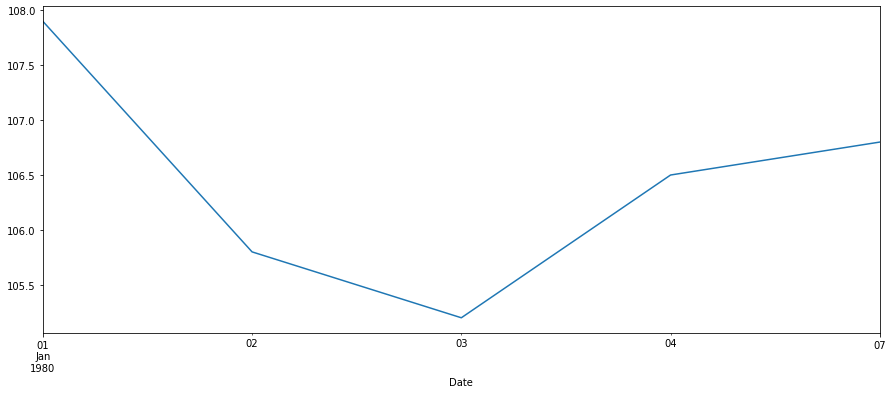

In [ ]:
finalData[:5].Price.plot()

In [ ]:
finalData.shape

(10643, 5)

In [ ]:
finalData

,Price,Open,High,Low,PE
Date,,,,,
1980-01-01,107.90,107.90,107.90,107.90,8.85
1980-01-02,105.80,105.80,108.40,105.30,8.85
1980-01-03,105.20,105.20,106.10,103.30,8.85
1980-01-04,106.50,106.50,107.10,105.10,8.85
1980-01-07,106.80,106.80,107.80,105.80,8.85
...,...,...,...,...,...
2022-03-07,4201.09,4327.01,4327.01,4199.85,34.14
2022-03-08,4170.62,4202.66,4276.94,4157.87,34.14
2022-03-09,4277.88,4223.10,4299.40,4223.10,34.14


In [ ]:
finalData = finalData.loc[:,["Price", "PE"]]

In [ ]:
sc = MinMaxScaler()
dScaled = sc.fit_transform(finalData)
dScaled

array([[0.00206455, 0.05885486],
       [0.00161759, 0.05885486],
       [0.00148988, 0.05885486],
       ...,
       [0.88960403, 0.73235686],
       [0.88569629, 0.73235686],
       [0.87394538, 0.73235686]])

In [ ]:
dScaled = np.append(dScaled, np.zeros([len(dScaled),1]),1)
n = 180
for i in range(n-1 ,len(dScaled)):
    x = dScaled[(i-n+1):(i+1)][:,0]
    y = dScaled[(i-n+1):(i+1)][:,1]
    cVal = pd.Series(x).corr(pd.Series(y))
    dScaled[i][2] = cVal
dScaled

array([[0.00206455, 0.05885486, 0.        ],
       [0.00161759, 0.05885486, 0.        ],
       [0.00148988, 0.05885486, 0.        ],
       ...,
       [0.88960403, 0.73235686, 0.68416064],
       [0.88569629, 0.73235686, 0.68418775],
       [0.87394538, 0.73235686, 0.68977301]])

In [ ]:
trueSamps = []
prev = 0
n = 180
for k in range(n-1, len(dScaled)):
    if dScaled[k][2] > 0.9 and k >= prev+n//3 and dScaled[k][0] == max(dScaled[(k-n+1):(k+1), 0]) and dScaled[k][0] > dScaled[k+1][0]:
        trueSamps.append(k)
        prev = k

In [ ]:
len(trueSamps)

31

In [ ]:
def iDataMaker(nDays,data,samps):
    allClassSamps = []
    for idx in samps:
        prevVals = [data[idx-i][0] for i in range(nDays)[::-1]]
        plt.axis('off')
        plt.plot(prevVals, color ="black")
        fig = plt.gcf()
        fig.set_size_inches(8, 8)
        fig.canvas.draw()
        allClassSamps.append(np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape((576,576,3)))
        fig.clear()
    return allClassSamps

In [ ]:
trueSampsImgs = iDataMaker(180, dScaled,trueSamps)

<Figure size 576x576 with 0 Axes>

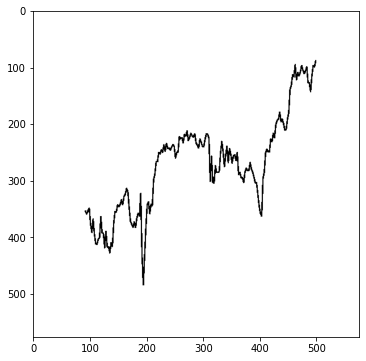

In [ ]:
plt.imshow(trueSampsImgs[23])

In [ ]:
falseSamps = []
prev = 0
n = 180
for k in range(n-1, len(dScaled)):
    if dScaled[k][2] < 0.5 and k >= prev+n//3 and dScaled[k][0] < max(dScaled[(k-n+1):(k+1), 0]) and dScaled[k][0] > dScaled[k+1][0]:
        falseSamps.append(k)
        prev = k

In [ ]:
len(falseSamps)

37

In [ ]:
falseSampsImgs = iDataMaker(180, dScaled,falseSamps)

<Figure size 576x576 with 0 Axes>

In [ ]:
trueSampsImgsResized = []
for i in trueSampsImgs:
    im = ImageOps.grayscale(Image.fromarray(i))
    im = im.resize((128,128), reducing_gap=3)
    trueSampsImgsResized.append((np.asarray(im)))

In [ ]:
falseSampsImgsResized = []
for i in falseSampsImgs:
    im = ImageOps.grayscale(Image.fromarray(i))
    im = im.resize((128,128), reducing_gap=3)
    falseSampsImgsResized.append((np.asarray(im)))

In [ ]:
trueLabs = np.ones(len(trueSampsImgsResized))

In [ ]:
falseLabs = np.zeros(len(falseSampsImgsResized))

In [ ]:
trueSampsImgsResized.extend(falseSampsImgsResized)

In [ ]:
X, y = np.array(trueSampsImgsResized), np.append(trueLabs,falseLabs)

In [ ]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size = 0.2, random_state=0)

In [ ]:
model = Sequential()
model.add(Convolution2D(4, (3,3), input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Convolution2D(4, (3,3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 4)       40        
                                                                 
 batch_normalization_6 (Batc  (None, 126, 126, 4)      16        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 126, 126, 4)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 4)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 4)         148       
                                                                 
 batch_normalization_7 (Batc  (None, 61, 61, 4)       

In [ ]:
model.fit(trainX, trainy, validation_data=(testX, testy), epochs=10)

Epoch 1/10
2/2 [==============================] - 2s 761ms/step - loss: 0.9004 - accuracy: 0.6111 - val_loss: 3.0194 - val_accuracy: 0.7143
Epoch 2/10
2/2 [==============================] - 1s 673ms/step - loss: 0.6568 - accuracy: 0.6296 - val_loss: 2.4958 - val_accuracy: 0.7143
Epoch 3/10
2/2 [==============================] - 1s 535ms/step - loss: 0.6235 - accuracy: 0.6481 - val_loss: 1.6330 - val_accuracy: 0.7143
Epoch 4/10
2/2 [==============================] - 1s 509ms/step - loss: 0.4283 - accuracy: 0.7593 - val_loss: 0.8833 - val_accuracy: 0.7143
Epoch 5/10
2/2 [==============================] - 1s 441ms/step - loss: 0.3334 - accuracy: 0.8704 - val_loss: 0.4642 - val_accuracy: 0.8571
Epoch 6/10
2/2 [==============================] - 1s 506ms/step - loss: 0.3052 - accuracy: 0.8519 - val_loss: 0.4940 - val_accuracy: 0.7143
Epoch 7/10
2/2 [==============================] - 1s 426ms/step - loss: 0.2528 - accuracy: 0.9074 - val_loss: 0.4345 - val_accuracy: 0.7857
Epoch 8/10
2/2 [====

Text(0.5, 1.0, 'Loss Plot')

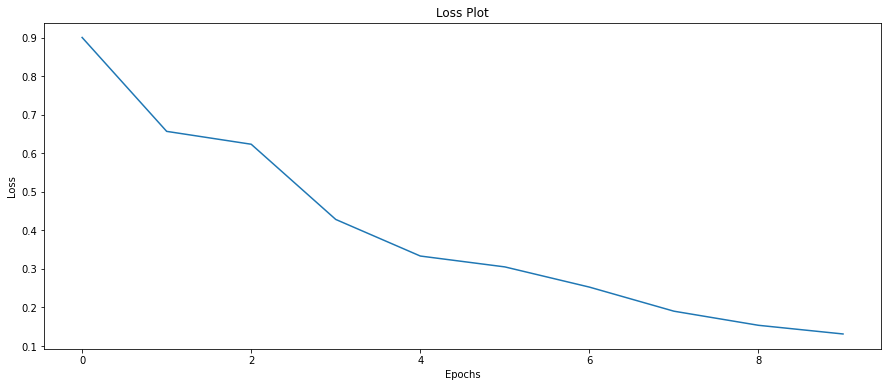

In [ ]:
pd.Series([0.9004,0.6568,0.6234,0.4283,0.3334,0.3052,0.2528,0.1903,0.1537,0.1312]).plot()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss Plot")

In [ ]:
model.predict(np.expand_dims(testX[0],0))[0][0]

0.05239606

In [ ]:
model.save("TrainedCNN-1.h5")

In [ ]:
pkl.dump(X, open("X.pkl","wb"))

In [ ]:
pkl.dump(y, open("y.pkl", "wb"))

In [ ]:
pkl.dump(dScaled, open("dScaledNoCNN.pkl", "wb"))

**Step 4 - (6 pts)** Train your CNN and RNN on your Training Set (S&P500 data and/or Schiller P/E data, from Step 1, above) then test to ensure it functions correctly when predicting the next one, two, three, and four trading data (average price or close price - either is o.k.) before you go on to Step 5.  Document your training results, as discussed here:

**TO-DOCUMENT:**  You get credit for showing your preliminary test results and discussing the number of training epochs (iterations through whatever backpropagation algorithm you use, and why this is so ...


In [ ]:
dScaled = pkl.load(open("/content/drive/MyDrive/NNDM-4/dScaledNoCNN.pkl", "rb"))

In [ ]:
model = load_model("/content/drive/MyDrive/NNDM-4/TrainedCNN-1.h5")

In [ ]:
dScaled

array([[0.00206455, 0.05885486, 0.        ],
       [0.00161759, 0.05885486, 0.        ],
       [0.00148988, 0.05885486, 0.        ],
       ...,
       [0.88960403, 0.73235686, 0.68416064],
       [0.88569629, 0.73235686, 0.68418775],
       [0.87394538, 0.73235686, 0.68977301]])

In [ ]:
modDScaled = dScaled.copy()

In [ ]:
def TS2IDS(n, data):
    data = np.append(data, np.zeros([len(data),1]),1)
    for i in range(n-1 ,len(data)):
        minix = data[(i-n+1):(i+1)][:,0]
        plt.axis('off')
        plt.plot(minix, color ="black")
        fig = plt.gcf()
        fig.set_size_inches(8, 8)
        fig.canvas.draw()
        minix = ImageOps.grayscale(Image.fromarray(np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape((576,576,3))))
        minix = minix.resize((128,128), reducing_gap=3)
        fig.clear()
        cVal = model.predict(np.expand_dims(minix,0))[0][0]
        data[i][3] = cVal
    return data

KeyboardInterrupt: ignored

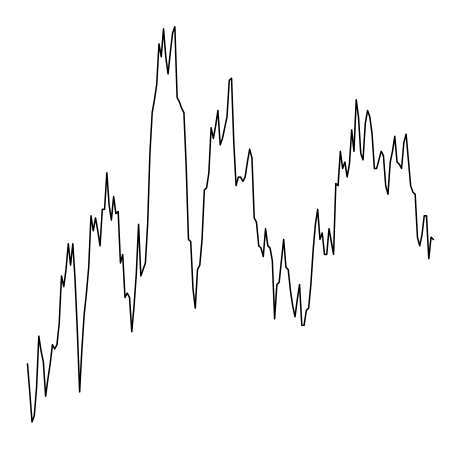

In [ ]:
data = TS2IDS(180, modDScaled)

In [ ]:
data

In [ ]:
pkl.dump(data, open("/content/drive/MyDrive/NNDM-4/dScaledWCNN.pkl", "wb"))

In [ ]:
data = pkl.load(open("/content/drive/MyDrive/NNDM-4/dScaledWCNN.pkl", "rb"))

In [ ]:
data[179:]

array([[0.00581054, 0.06471372, 0.50898097, 0.37321699],
       [0.00585311, 0.06471372, 0.5147943 , 0.32595578],
       [0.00606595, 0.06471372, 0.52188605, 0.33395278],
       ...,
       [0.88960403, 0.73235686, 0.68416064, 0.29486597],
       [0.88569629, 0.73235686, 0.68418775, 0.12046766],
       [0.87394538, 0.73235686, 0.68977301, 0.06136179]])

In [ ]:
def makeGenerator(scaled_train, n_input):
    generator = TimeseriesGenerator(scaled_train, scaled_train[:,0], length=n_input, batch_size=1)
    return generator

In [ ]:
#Keeping 1000 for prediction and 500 for validation
generator = makeGenerator(data[179:-1500], 16)
valGenerator = makeGenerator(data[-1500:-1000], 16)
testGenerator = makeGenerator(data[-1000:], 16)

In [ ]:
valDataX = []
valDataY = []
for i in range(500-17):
    valDataX.append(valGenerator[i][0])
    valDataY.append(valGenerator[i][1])
valDataX = np.array(valDataX)
valDataY = np.array(valDataY)

In [ ]:
testDataX = []
testDataY = []
for i in range(1000-17):
    testDataX.append(testGenerator[i][0])
    testDataY.append(testGenerator[i][1])
testDataX = np.array(testDataX)
testDataY = np.array(testDataY)

In [ ]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(10, activation='tanh', input_shape=(16,4)))
modelLSTM.add(Dense(1))
modelLSTM.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
modelLSTM.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                600       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelLSTM.fit_generator(generator=generator, validation_data=(valDataX, valDataY), epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


8948/8948 [==============================] - 118s 13ms/step - loss: 1.8149e-04 - accuracy: 0.0000e+00 - val_loss: 2.5765e-05 - val_accuracy: 0.0000e+00
Epoch 2/10
8948/8948 [==============================] - 94s 11ms/step - loss: 3.1613e-05 - accuracy: 0.0000e+00 - val_loss: 3.3935e-05 - val_accuracy: 0.0000e+00
Epoch 3/10
8948/8948 [==============================] - 94s 10ms/step - loss: 2.1966e-05 - accuracy: 0.0000e+00 - val_loss: 1.7098e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
8948/8948 [==============================] - 93s 10ms/step - loss: 1.8434e-05 - accuracy: 0.0000e+00 - val_loss: 1.7383e-07 - val_accuracy: 0.0000e+00
Epoch 5/10
8948/8948 [==============================] - 94s 10ms/step - loss: 1.5430e-05 - accuracy: 0.0000e+00 - val_loss: 8.1069e-06 - val_accuracy: 0.0000e+00
Epoch 6/10
8948/8948 [==============================] - 95s 11ms/step - loss: 1.5528e-05 - accuracy: 0.0000e+00 - val_loss: 7.1306e-05 - val_accuracy: 0.0000e+00
Epoch 7/10
8948/8948 [================

In [ ]:
pkl.dump(sc, open("/content/drive/MyDrive/NNDM-4/scaler-1.pkl","wb"))

In [ ]:
pkl.dump(modelLSTM, open("/content/drive/MyDrive/NNDM-4/TrainedLSTM-1.h5","wb"))

INFO:tensorflow:Assets written to: ram://b8b69f1a-c109-4463-bcad-20bb64294839/assets


INFO:tensorflow:Assets written to: ram://b8b69f1a-c109-4463-bcad-20bb64294839/assets


In [ ]:
modelLSTM.save("/content/drive/MyDrive/NNDM-4/TrainedLSTM-1-KSave-REAL.h5")

In [ ]:
preds = []
actual = []
for i in range(983):
    preds.append(sc.inverse_transform(np.array([[modelLSTM.predict(testDataX[i]),0]])))
    actual.append(sc.inverse_transform(np.array([[testDataY[i],0]])))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

Text(0, 0.5, 'S&P Value')

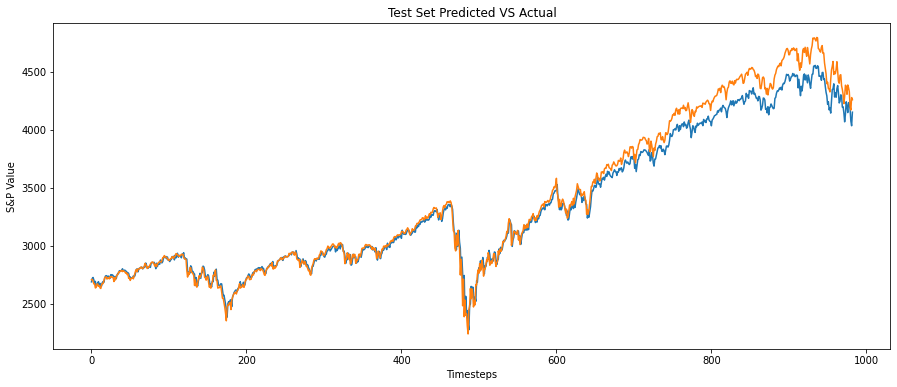

In [ ]:
pd.Series([preds[i][0][0] for i in range(983)]).plot()
pd.Series([actual[i][0][0] for i in range(983)]).plot()
plt.title("Test Set Predicted VS Actual")
plt.xlabel("Timesteps")
plt.ylabel("S&P Value")

In [ ]:
pd.DataFrame({"actual":pd.Series([actual[i][0][0] for i in range(983)]), "preds":pd.Series([preds[i][0][0] for i in range(983)])
}).to_csv("/content/drive/MyDrive/NNDM-4/Results-1.csv")

In [ ]:
preds = []
actual = []
for i in range(983):
    preds.append(sc.inverse_transform(np.array([[modelLSTM.predict(np.array([testData4X[i]]))[0][0],0]]))[0][0])
    actual.append(sc.inverse_transform([[testData4Y[i][0][0], 0]])[0][0])

In [ ]:
preds2 = []
for i in range(0,len(testData4X),2):
    pred1 = modelLSTM.predict(np.expand_dims(testData4X[i], 0))
    pred2 = modelLSTM.predict(np.expand_dims(np.append(testData4X[0][1:], pred1, axis=0), 0))
    preds2.append(pred1)
    preds2.append(pred2)

Text(0, 0.5, 'S&P Value')

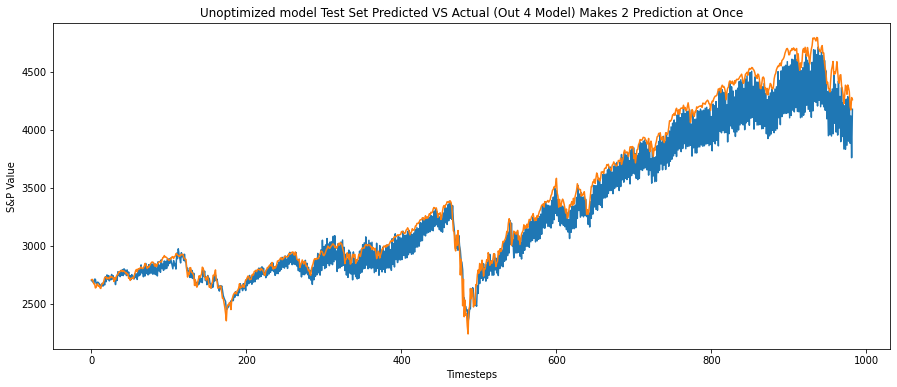

In [ ]:
pd.Series([sc.inverse_transform(np.array([[preds[i][0][0],0]]))[0][0] for i in range(983)]).plot()
pd.Series([sc.inverse_transform(np.array([[testData4Y[i][0][0], 0]]))[0][0] for i in range(983)]).plot()
plt.title("Unoptimized model Test Set Predicted VS Actual (Out 4 Model) Makes 2 Prediction at Once")
plt.xlabel("Timesteps")
plt.ylabel("S&P Value")

In [ ]:
preds3 = []
for i in range(0,len(testData4X),3):
    pred1 = modelLSTM2.predict(np.expand_dims(testData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    preds2.append(pred1)
    preds2.append(pred2)
    preds2.append(pred3)

In [ ]:
pd.Series([sc.inverse_transform(np.array([[preds3[i][0][0],0]]))[0][0] for i in range(983)]).plot()
pd.Series([sc.inverse_transform(np.array([[testData4Y[i][0][0], 0]]))[0][0] for i in range(983)]).plot()
plt.title("Unoptimized model Test Set Predicted VS Actual (Out 4 Model) Makes 3 Prediction at Once")
plt.xlabel("Timesteps")
plt.ylabel("S&P Value")

**Step 6 - (3 pts)** Optimize your CNN+RNN algorithm's performance to yield maximum achievable accuracy (e.g., minimum prediction_error) over the entire Training Set and Test Set.  Repeat Step 5 graphing operation to show this optimized result.  Be sure to change the graph title to include the phrase "Optimized Over All Data". True Step 5 down below

In [ ]:
def make4ValGenerator(scaled_train, n_input):
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
    return generator

In [ ]:
generator4Val = make4ValGenerator(data[179:-1500], 16)
valGenerator4Val = make4ValGenerator(data[-1500:-1000], 16)
testGenerator4Val = make4ValGenerator(data[-1000:], 16)

In [ ]:
trainData4X = []
trainData4Y = []
for i in range(len(data[179:-1500])-17):
    trainData4X.append(generator4Val[i][0])
    trainData4Y.append(generator4Val[i][1])
trainData4X = np.array(trainData4X).reshape(-1,16,4)
trainData4Y = np.array(trainData4Y)

In [ ]:
valData4X = []
valData4Y = []
for i in range(500-17):
    valData4X.append(valGenerator4Val[i][0])
    valData4Y.append(valGenerator4Val[i][1])
valData4X = np.array(valData4X).reshape(-1,16,4)
valData4Y = np.array(valData4Y)

In [ ]:
testData4X = []
testData4Y = []
for i in range(1000-17):
    testData4X.append(testGenerator4Val[i][0])
    testData4Y.append(testGenerator4Val[i][1])
testData4X = np.array(testData4X).reshape(-1,16,4)
testData4Y = np.array(testData4Y)

In [ ]:
modelLSTM2 = Sequential()
modelLSTM2.add(LSTM(32, activation='tanh', input_shape=(16,4)))
modelLSTM2.add(Dense(4))
modelLSTM2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
modelLSTM2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 4,868
Trainable params: 4,868
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelLSTM2.fit_generator(generator=generator4Val, validation_data=(valData4X, valData4Y), epochs=15)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


8948/8948 [==============================] - 45s 5ms/step - loss: 0.0053 - accuracy: 0.9345 - val_loss: 0.0099 - val_accuracy: 0.9528
Epoch 2/15
8948/8948 [==============================] - 43s 5ms/step - loss: 0.0042 - accuracy: 0.9447 - val_loss: 0.0100 - val_accuracy: 0.9573
Epoch 3/15
8948/8948 [==============================] - 43s 5ms/step - loss: 0.0042 - accuracy: 0.9442 - val_loss: 0.0099 - val_accuracy: 0.9554
Epoch 4/15
8948/8948 [==============================] - 42s 5ms/step - loss: 0.0041 - accuracy: 0.9471 - val_loss: 0.0099 - val_accuracy: 0.9534
Epoch 5/15
8948/8948 [==============================] - 43s 5ms/step - loss: 0.0041 - accuracy: 0.9475 - val_loss: 0.0095 - val_accuracy: 0.9541
Epoch 6/15
8948/8948 [==============================] - 44s 5ms/step - loss: 0.0040 - accuracy: 0.9484 - val_loss: 0.0094 - val_accuracy: 0.9541
Epoch 7/15
8948/8948 [==============================] - 44s 5ms/step - loss: 0.0040 - accuracy: 0.9487 - val_loss: 0.0096 - val_accuracy: 0.9

In [ ]:
modelLSTM2.save("/content/drive/MyDrive/NNDM-4/TrainedLSTM-2-KSave-REAL.h5")

In [ ]:
modelLSTM2 = load_model("/content/drive/MyDrive/NNDM-4/TrainedLSTM-2-KSave-REAL.h5")

**Step 5 - (6 pts)** Test your CNN and RNN accuracy over Test Data on which you did not train, to determine how well your neural networks generalize -- specifically, in terms of predicting the next one, two, three, and four datapoints in the dataset from 1 Jan 1980 (or whenever your dataset begins) through the present day (or whenever your dataset ends).  To determine response to input nonergodicity, it is suggested that you use a sliding sampling window of N datapoints for testing your algorithm, sliding the window along the test data and applying your CNN+RNN algorithm to determine how well (at each data point in the Test Data) your algorithm predicts the next one to four datapoints.  

Accuracy will be computed in terms of error defined as 

prediction_error := (predicted_price - actual_price) / actual_price 

(Hint: You will want to develop a script to do this, as there will be multiple execution runs)

**TO-DOCUMENT:**  Graph prediction_error as a function of timestamp (e.g., DD/MM/YYYY) for all data in the Training Set, as shown in Figure 2.  Produce a similar graph for the Test Set (clearly, there will be some overlap between the two graphs, depending on the length of your sampling window). Here is an example of the type of graph you should produce (you can MS-Excel for this):
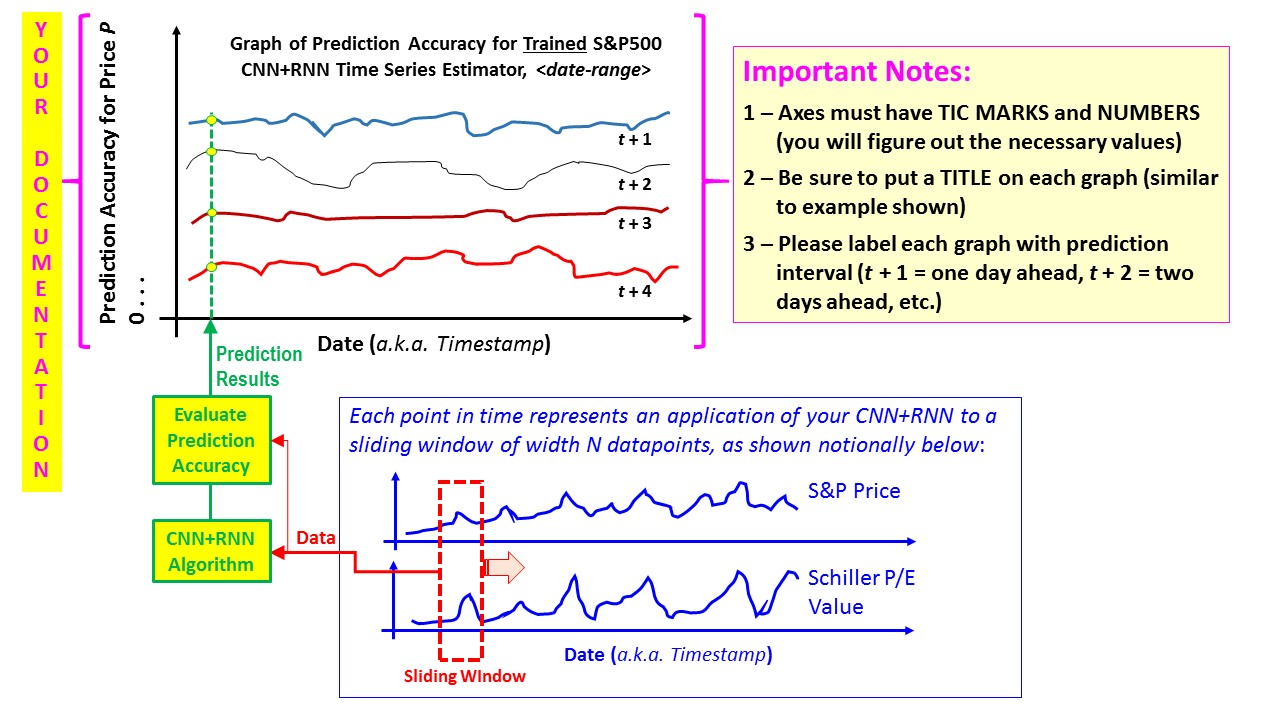
Figure 2:  Notional example of Price Prediction Accuracy Graph (between magenta-colored braces), and how the sliding window approach works to generate the individual traces on the graph for predicting one to four days ahead of current time.  


In [ ]:
preds4 = []
actual4 = []
for i in range(983):
    preds4.append(sc.inverse_transform(np.array([[modelLSTM2.predict(np.array([testData4X[i]]))[0][0],0]]))[0][0])
    actual4.append(sc.inverse_transform([[testData4Y[i][0][0], 0]])[0][0])

Text(0, 0.5, 'S&P Value')

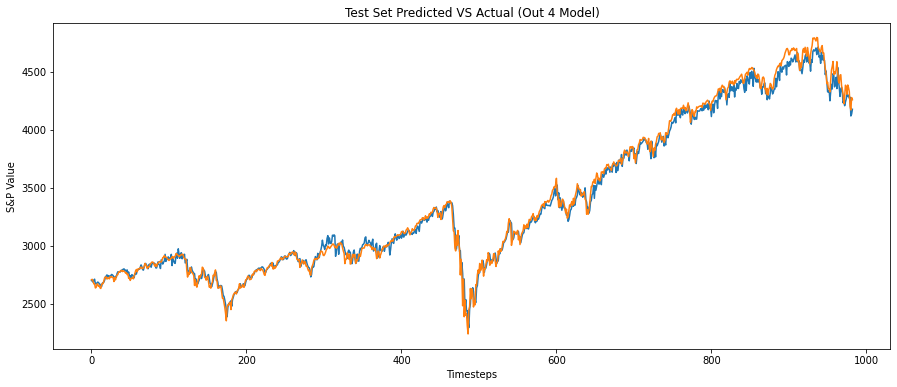

In [ ]:
pd.Series([preds4[i] for i in range(983)]).plot()
pd.Series([actual4[i] for i in range(983)]).plot()
plt.title("Test Set Predicted VS Actual (Out 4 Model)")
plt.xlabel("Timesteps")
plt.ylabel("S&P Value")

In [ ]:
pd.DataFrame({"actual":actual4, "preds":preds4}).to_csv("/content/drive/MyDrive/NNDM-4/Results-2.csv")

In [ ]:
modelLSTM2.predict(np.expand_dims(testData4X[0], 0))

array([[0.553237  , 0.6706704 , 0.87098694, 0.41364837]], dtype=float32)

In [ ]:
modelLSTM2.predict(np.expand_dims(np.append(testData4X[0][1:], modelLSTM2.predict(np.expand_dims(testData4X[0], 0)), axis=0), 0))

array([[0.55465436, 0.67611533, 0.86702645, 0.39760932]], dtype=float32)

In [ ]:
preds = []
for i in range(0,len(testData4X),2):
    pred1 = modelLSTM2.predict(np.expand_dims(testData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][1:], pred1, axis=0), 0))
    preds.append(pred1)
    preds.append(pred2)

Text(0, 0.5, 'S&P Value')

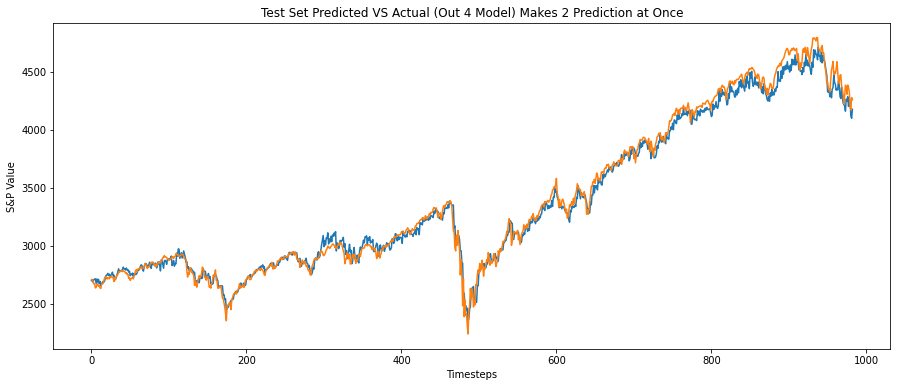

In [ ]:
pd.Series([sc.inverse_transform(np.array([[preds[i][0][0],0]]))[0][0] for i in range(983)]).plot()
pd.Series([sc.inverse_transform(np.array([[testData4Y[i][0][0], 0]]))[0][0] for i in range(983)]).plot()
plt.title("Test Set Predicted VS Actual (Out 4 Model) Makes 2 Prediction at Once")
plt.xlabel("Timesteps")
plt.ylabel("S&P Value")

In [ ]:
preds2 = []
for i in range(0,len(testData4X),3):
    pred1 = modelLSTM2.predict(np.expand_dims(testData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    preds2.append(pred1)
    preds2.append(pred2)
    preds2.append(pred3)

Text(0, 0.5, 'S&P Value')

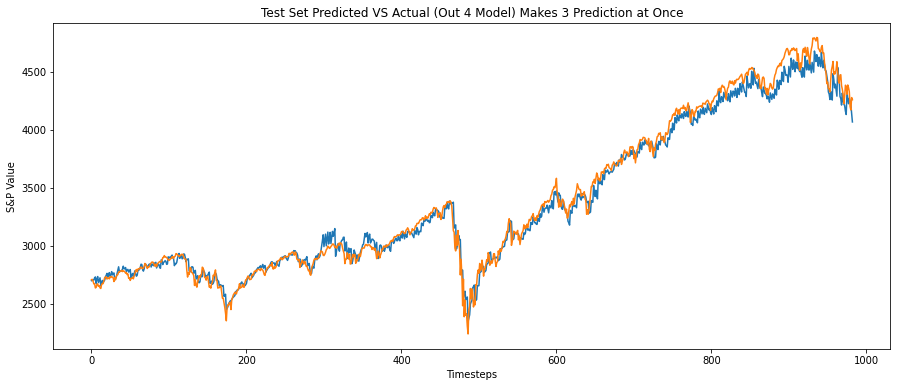

In [ ]:
pd.Series([sc.inverse_transform(np.array([[preds2[i][0][0],0]]))[0][0] for i in range(983)]).plot()
pd.Series([sc.inverse_transform(np.array([[testData4Y[i][0][0], 0]]))[0][0] for i in range(983)]).plot()
plt.title("Test Set Predicted VS Actual (Out 4 Model) Makes 3 Prediction at Once")
plt.xlabel("Timesteps")
plt.ylabel("S&P Value")

In [ ]:
preds3 = []
for i in range(0,len(testData4X),4):
    pred1 = modelLSTM2.predict(np.expand_dims(testData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    pred4 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][3:], np.append(np.append(pred1, pred2, axis=0), pred3, axis=0), axis=0), 0))
    preds3.append(pred1)
    preds3.append(pred2)
    preds3.append(pred3)
    preds3.append(pred4)

Text(0, 0.5, 'S&P Value')

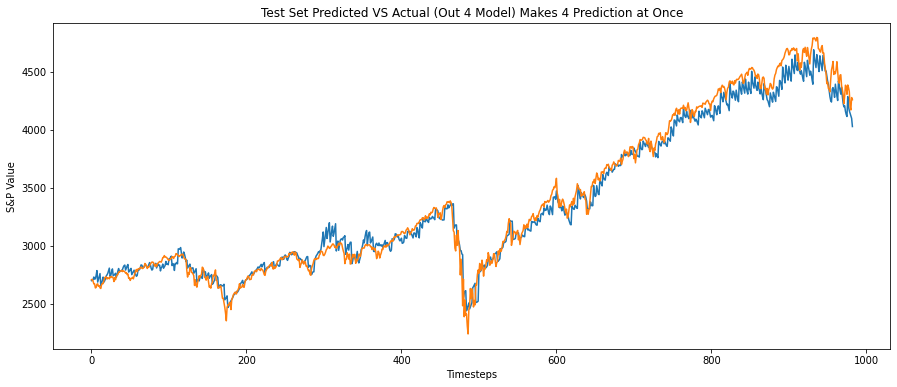

In [ ]:
pd.Series([sc.inverse_transform(np.array([[preds3[i][0][0],0]]))[0][0] for i in range(983)]).plot()
pd.Series([sc.inverse_transform(np.array([[testData4Y[i][0][0], 0]]))[0][0] for i in range(983)]).plot()
plt.title("Test Set Predicted VS Actual (Out 4 Model) Makes 4 Prediction at Once")
plt.xlabel("Timesteps")
plt.ylabel("S&P Value")

In [ ]:
actualValues = pd.Series([actual4[i] for i in range(983)])
pred1Values = pd.Series([preds4[i] for i in range(983)])
pred2Values = pd.Series([sc.inverse_transform(np.array([[preds[i][0][0],0]]))[0][0] for i in range(983)])
pred3Values = pd.Series([sc.inverse_transform(np.array([[preds2[i][0][0],0]]))[0][0] for i in range(983)])
pred4Values = pd.Series([sc.inverse_transform(np.array([[preds3[i][0][0],0]]))[0][0] for i in range(983)])

Text(0.5, 1.0, 'Prediction errors for various time step predictions')

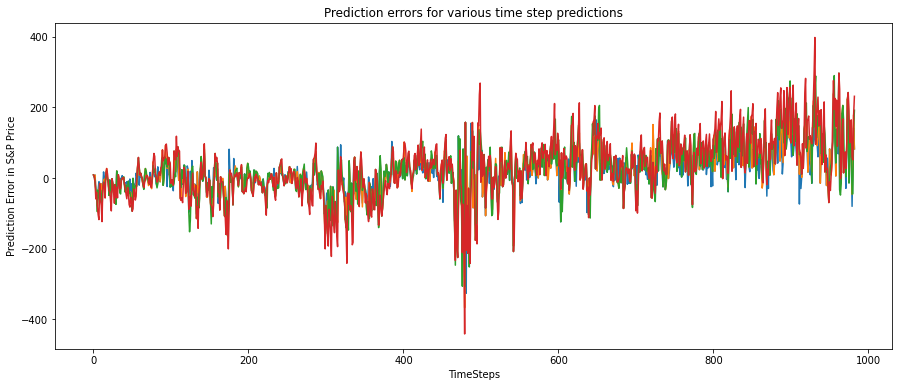

In [ ]:
(actualValues - pred1Values).plot()
(actualValues - pred2Values).plot()
(actualValues - pred3Values).plot()
(actualValues - pred4Values).plot()
plt.xlabel("TimeSteps")
plt.ylabel("Prediction Error in S&P Price")
plt.title("Prediction errors for various time step predictions")

In [ ]:
pred1[0][0]

0.009715114

In [ ]:
# Prepping data from all time 
#Predicting on trained Data
tPred1 = []
for i in range(0,len(trainData4X),2):
    tPred1.append(sc.inverse_transform(np.array([[modelLSTM2.predict(np.expand_dims(trainData4X[i], 0))[0][0],0]]))[0][0])
tPred2 = []
for i in range(0,len(trainData4X),2):
    pred1 = modelLSTM2.predict(np.expand_dims(trainData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(trainData4X[i][1:], pred1, axis=0), 0))
    tPred2.append(sc.inverse_transform(np.array([[pred1[0][0],0]]))[0][0])
    tPred2.append(sc.inverse_transform(np.array([[pred2[0][0],0]]))[0][0])
tPred3 = []
for i in range(0,len(trainData4X),3):
    pred1 = modelLSTM2.predict(np.expand_dims(trainData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(trainData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(trainData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    tPred3.append(sc.inverse_transform(np.array([[pred1[0][0],0]]))[0][0])
    tPred3.append(sc.inverse_transform(np.array([[pred2[0][0],0]]))[0][0])
    tPred3.append(sc.inverse_transform(np.array([[pred3[0][0],0]]))[0][0])
tPred4 = []
for i in range(0,len(trainData4X),4):
    pred1 = modelLSTM2.predict(np.expand_dims(trainData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(trainData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(trainData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    pred4 = modelLSTM2.predict(np.expand_dims(np.append(trainData4X[i][3:], np.append(np.append(pred1, pred2, axis=0), pred3, axis=0), axis=0), 0))
    tPred4.append(sc.inverse_transform(np.array([[pred1[0][0],0]]))[0][0])
    tPred4.append(sc.inverse_transform(np.array([[pred2[0][0],0]]))[0][0])
    tPred4.append(sc.inverse_transform(np.array([[pred3[0][0],0]]))[0][0])
    tPred4.append(sc.inverse_transform(np.array([[pred4[0][0],0]]))[0][0])
#Predicting on validation Data
vPred1 = []
for i in range(0,len(valData4X),2):
    vPred1.append(sc.inverse_transform(np.array([[modelLSTM2.predict(np.expand_dims(trainData4X[i], 0))[0][0],0]]))[0][0])
vPred2 = []
for i in range(0,len(valData4X),2):
    pred1 = modelLSTM2.predict(np.expand_dims(valData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(valData4X[i][1:], pred1, axis=0), 0))
    vPred2.append(sc.inverse_transform(np.array([[pred1,0]]))[0][0])
    vPred2.append(sc.inverse_transform(np.array([[pred2,0]]))[0][0])
vPred3 = []
for i in range(0,len(valData4X),3):
    pred1 = modelLSTM2.predict(np.expand_dims(valData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(valData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(valData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    vPred3.append(sc.inverse_transform(np.array([[pred1,0]]))[0][0])
    vPred3.append(sc.inverse_transform(np.array([[pred2,0]]))[0][0])
    vPred3.append(sc.inverse_transform(np.array([[pred3,0]]))[0][0])
vPred4 = []
for i in range(0,len(valData4X),4):
    pred1 = modelLSTM2.predict(np.expand_dims(valData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(valData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(valData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    pred4 = modelLSTM2.predict(np.expand_dims(np.append(valData4X[i][3:], np.append(np.append(pred1, pred2, axis=0), pred3, axis=0), axis=0), 0))
    vPred4.append(sc.inverse_transform(np.array([[pred1,0]]))[0][0])
    vPred4.append(sc.inverse_transform(np.array([[pred2,0]]))[0][0])
    vPred4.append(sc.inverse_transform(np.array([[pred3,0]]))[0][0])
    vPred4.append(sc.inverse_transform(np.array([[pred4,0]]))[0][0])
# Predicting on test data
tePred1 = []
for i in range(0,len(testData4X),2):
    tePred1.append(sc.inverse_transform(np.array([[modelLSTM2.predict(np.expand_dims(trainData4X[i], 0))[0][0],0]]))[0][0])
tePred2 = []
for i in range(0,len(testData4X),2):
    pred1 = modelLSTM2.predict(np.expand_dims(testData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][1:], pred1, axis=0), 0))
    tePred2.append(sc.inverse_transform(np.array([[pred1,0]]))[0][0])
    tePred2.append(sc.inverse_transform(np.array([[pred2,0]]))[0][0])
tePred3 = []
for i in range(0,len(testData4X),3):
    pred1 = modelLSTM2.predict(np.expand_dims(testData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    tePred3.append(sc.inverse_transform(np.array([[pred1,0]]))[0][0])
    tePred3.append(sc.inverse_transform(np.array([[pred2,0]]))[0][0])
    tePred3.append(sc.inverse_transform(np.array([[pred3,0]]))[0][0])
tePred4 = []
for i in range(0,len(testData4X),4):
    pred1 = modelLSTM2.predict(np.expand_dims(testData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    pred4 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][3:], np.append(np.append(pred1, pred2, axis=0), pred3, axis=0), axis=0), 0))
    tePred4.append(sc.inverse_transform(np.array([[pred1,0]]))[0][0])
    tePred4.append(sc.inverse_transform(np.array([[pred2,0]]))[0][0])
    tePred4.append(sc.inverse_transform(np.array([[pred3,0]]))[0][0])
    tePred4.append(sc.inverse_transform(np.array([[pred4,0]]))[0][0])



KeyboardInterrupt: ignored

In [ ]:
tPred4 = []
for i in range(0,len(trainData4X),4):
    pred1 = modelLSTM2.predict(np.expand_dims(trainData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(trainData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(trainData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    pred4 = modelLSTM2.predict(np.expand_dims(np.append(trainData4X[i][3:], np.append(np.append(pred1, pred2, axis=0), pred3, axis=0), axis=0), 0))
    tPred4.append(sc.inverse_transform(np.array([[pred1[0][0],0]]))[0][0])
    tPred4.append(sc.inverse_transform(np.array([[pred2[0][0],0]]))[0][0])
    tPred4.append(sc.inverse_transform(np.array([[pred3[0][0],0]]))[0][0])
    tPred4.append(sc.inverse_transform(np.array([[pred4[0][0],0]]))[0][0])
vPred4 = []
for i in range(0,len(valData4X),4):
    pred1 = modelLSTM2.predict(np.expand_dims(valData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(valData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(valData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    pred4 = modelLSTM2.predict(np.expand_dims(np.append(valData4X[i][3:], np.append(np.append(pred1, pred2, axis=0), pred3, axis=0), axis=0), 0))
    vPred4.append(sc.inverse_transform(np.array([[pred1[0][0],0]]))[0][0])
    vPred4.append(sc.inverse_transform(np.array([[pred2[0][0],0]]))[0][0])
    vPred4.append(sc.inverse_transform(np.array([[pred3[0][0],0]]))[0][0])
    vPred4.append(sc.inverse_transform(np.array([[pred4[0][0],0]]))[0][0])
tePred4 = []
for i in range(0,len(testData4X),4):
    pred1 = modelLSTM2.predict(np.expand_dims(testData4X[i], 0))
    pred2 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][1:], pred1, axis=0), 0))
    pred3 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][2:], np.append(pred1, pred2, axis=0), axis=0), 0))
    pred4 = modelLSTM2.predict(np.expand_dims(np.append(testData4X[i][3:], np.append(np.append(pred1, pred2, axis=0), pred3, axis=0), axis=0), 0))
    tePred4.append(sc.inverse_transform(np.array([[pred1[0][0],0]]))[0][0])
    tePred4.append(sc.inverse_transform(np.array([[pred2[0][0],0]]))[0][0])
    tePred4.append(sc.inverse_transform(np.array([[pred3[0][0],0]]))[0][0])
    tePred4.append(sc.inverse_transform(np.array([[pred4[0][0],0]]))[0][0])

In [ ]:
for i in vPred4:
    tPred4.append(i)

for i in tePred4:
    tPred4.append(i)

    

In [ ]:
allAct = []
for i in trainData4Y:
    allAct.append(sc.inverse_transform([[i[0][0], 0]])[0][0])

for i in valData4Y:
    allAct.append(sc.inverse_transform([[i[0][0], 0]])[0][0])

for i in testData4Y:
    allAct.append(sc.inverse_transform([[i[0][0], 0]])[0][0])

In [ ]:
pd.DataFrame({"vals": tPred4[:10413], "actual": allAct}).to_csv("4aO.csv")

In [ ]:
savez_compressed("train.npz", trainData4X)
savez_compressed("val.npz", valData4X)
savez_compressed("test.npz", testData4X)

**BUYING AS WELL AS SELLING BOT AVAILABLE IN EXTRA CREDIT SECTION OF THE DOCUMENT**<HR>
**Step 7 - (3 pts)** Enhance your CNN+RNN algorithm's functionality to generate a SELL signal when the S&P500 is about to peak, then use the algorithm you developed in Step 2 of this assignment to check your CNN+RNN algorthm's profitability against.the correlation-based result you computed in Step 2.  

TO-DOCUMENT:  Make a simple graph or table of how much money you have left at the end of your trading activity, say, at each SELL point (with no tax or commission-fees penalties) - assuming you start with $1 million.

Step 8 - (3 pts)  Determine the Effect of Input Data Perturbations (Price Uncertainty) on your CNN+RNN Algorithm:

In real-time trading (which the pro's do - and sometimes "lose their shirts"), there may be some uncertainty in the reported prices.  This is because the prices that we see on a site such as bigcharts.com are delayed at least 10-15 minutes, so there might be some "settling time".  In real-time trading, especially in less-liquid commodities, there are occasional price inaccuracies and (very occasionally) time-lags in data reporting.  If you are wagering large amounts of money on a particular financial instrument, and your algorithm is not robust, then you too can "lose your shirt".  So, here is what we will do to give you an idea of this effect, and how it can corrupt the output of your CNN+RNN:

**8a)** Using your Optimized CNN+RNN algorithm (from Step 6, above) corrupt your Test Set that you used in Step 5, above:<br>
Add noise to the S&P 500 price data - NOT to the Schiller P/E data.  This is practicable, because the "Schiller P/E 10" is an ensemble measure, whereby input uncertainties tend to be somewhat "averaged out".<br>
        Noise will be Gaussian-distributed with 10 percent cross-section (e.g., 18 noise corrupted values out of each 180-value sampling window) and have zero mean, and standard deviation of (0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, and 0.1) -- assuming that the source dataset (from 1, above) has normalized value range equal to the real-valued interval [0,1].  You can scale this accordingly within your sampling window shown in FIgure 2.<br>
        Algorithm:  (1) generate random noise with std-dev as described above, (2) add noise values to input image every 10 values or so (chosen randomly), (3) DO NOT renormalize the noise-corrupted price data (unlike what you did with imagery in Programming Assignments 1-3) -- however, any negative values that result from noise corruption of S&P500 price data should be set to some small value greater than zero (you choose what that value is), for physical realism.

Hint:  You may recycle the noise generation algorithm(s) you developed for Programming Assignments 1 through 3.

**8b)** Repeat Tests in Step 6, above, with noise-corrupted Test Set.
Make four graphs like that shown in Figure 2, where each graph is specific to a prediction interval (e.g., one graph for the next sample denoted by time t + 1, another for t + 2, etc.).  Instead of the prediction intervals as traces on one graph, you should use for each prediction-interval graph the different noise level results.  So you will have nine traces (one per each noise level) on each of the four graphs --similar in concept to what you did for Programming Assignment 3.<br>
        Also, add to each graph title "Optimized" and "Noise-Corrupted Data".

IMPORTANT:  You must use your Optimized CNN+RNN for best performance before generating and reporting final results.

**8c)** Repeat Step 7, above, to Determine How Much Money You Make or Lose when the input is perturbed. 

        Make a table or simple graph for each prediction interval (i.e., t + 1, t + 2, etc.) of your profit (or loss ...) with results for each noise level in a separate column. 
        Example Table for one-day lookahead prediction

      Table of Prediction Error for CNN+RNN Applied to S&P500 data with Noisy Input
         Number of Inputs  =     _____ per sampling window
         Number of Layers =      _____
         Number of Outputs =     _____
         Days-Ahead Prediction = _____  <== Value ranges from 1 to 4

                   -- Gaussian Noise Standard Deviation  (10 percent cross-section) --
         Time      stdev - 0     stdev = 0.001    stdev = 0.002    ...    stdev = 0.1
         Stamp     Fh    Ffa     Fh      Ffa      Fh      Ffa      ...    Fh      Ffa
         -----     ----  ----    -----   -----    -----  -----            -----  -----
         6/1/80
         6/2/80                  <prediction_error values go here>
          :
         etc.                        So you make ONE of this kind of table for each prediction interval (1,2,3,4 days)

In [ ]:
finalData.loc[:, ['Price', 'Value']]

,Price,Value
Date,,
1980-01-01,107.90,8.85
1980-01-02,105.80,8.85
1980-01-03,105.20,8.85
1980-01-04,106.50,8.85
1980-01-07,106.80,8.85
...,...,...
2022-03-07,4201.09,34.14
2022-03-08,4170.62,34.14
2022-03-09,4277.88,34.14


In [ ]:
def getPerturbed(data, mu, sigma, ratio):
    idxCol = data.index
    rlocs = random.sample(range(0, len(data)), int(ratio*len(data)))
    for i in rlocs:
        noise = np.random.normal(mu, sigma)
        cidx = idxCol[i]
        data.loc[cidx, 'Price'] = data.loc[cidx, 'Price'] + noise
    return data

In [ ]:
def generateErrorDocs():
    pertData = getPerturbed(finalData)
    newScaledDataWSignal = TS2IDS(180, )


Step 9 - (4 pts + 2 extra-credit points for quality of appearance and level of detail&explanation)  Document and discuss your network parameters and results (e.g., number of layers, number of input and output data values, any assumptions you make about the activation function(s) and training algorithms/parameters, etc. --- and the configuration of your RNN.  Documentation should be in a PDF file with one-inch margins and 12-point TimesNewRoman type, which must be organized as follows:

1. Title Block = "CAP 6615 - Neural Networks - Programming Assignment 4 -- CNN+RNN for Time Series Prediction", followed by your group members' names and "Spring Semester 2022" and "08 April 2022" (each on a separate line)
Network parameters
2. A summary of your Python code for your correlation algorithm (Step 2), CNN and RNN algorithm (and put it in one file with extension .py -- to be turned in to Canvas) -- Actual code should be placed in an Appendix at the end of this report.
3. Training and Test set configuration (show images in a nicely formatted figure)
Unoptimized CNN+RNN output results (from Step 5), Optimized RNN results (from Step 6)
4. A summary of your code for algorithms you used to compute noisy data and prediction_error -- Actual code should be placed in an Appendix at the end of this report.
5. Optimized CNN+RNN output graphs (and tables, as applicable) for noise-free Training and Test Set inputs, then noise-corrupted inputs.
6. Discussion (in detail) of why your CNN+RNN performed the way it did, the effect of input perturbations, and how you could improve their performance in future.

**LINK TO OUR DOCUMENTATION:** https://docs.google.com/document/d/14NmODKrLPURucX7Z5YAViNpE0YLetNblBHLJvjTBjDs/edit?usp=sharing

# Extra Credit

In [ ]:
stonks = pd.read_csv('/content/drive/MyDrive/NNDM-4/4aO.csv')

investment_history = []
price_pred = stonks.vals.values
real = stonks.actual.values
investment_amount = 1000000
units = 0
stock_count = 0
i = 200
while i < len(stonks)-4:
  if np.mean(price_pred[i+1:i+5]) > real[i]:
    if (100 * investment_amount // 100) > real[i]:
      units = (100 * investment_amount // 100) // real[i]
      investment_amount -= units * real[i]
      stock_count += units
      print("Bought {} units. Investment amount = {}".format(units, investment_amount))
  elif np.mean(real[i-200:i]) > np.mean(real[i-5:i]):
    investment_amount += stock_count * real[i]
    print("Sold {} units. Investment amount = {}".format(stock_count, investment_amount))
    stock_count = 0
    if i + 5 < len(stonks)-4:
      i += 5
    else:
      investment_history.append(investment_amount + stock_count * real[i])
      break
  else:
    print("Hold")
  investment_history.append(investment_amount + stock_count * real[i])
  i += 1
print("Final portfolio amount = ", investment_history[-1])

Bought 7849.0 units. Investment amount = 37.39999999990687
Sold 7849.0 units. Investment amount = 1013343.2999999998
Bought 7636.0 units. Investment amount = 46.0999999998603
Sold 7636.0 units. Investment amount = 1006470.8999999999
Hold
Bought 7736.0 units. Investment amount = 17.29999999993015
Sold 7736.0 units. Investment amount = 1009565.2999999999
Bought 8174.0 units. Investment amount = 76.29999999993015
Sold 8174.0 units. Investment amount = 979321.4999999999
Bought 8464.0 units. Investment amount = 36.69999999983702
Sold 8464.0 units. Investment amount = 1045340.6999999998
Bought 8356.0 units. Investment amount = 5.099999999860302
Sold 8356.0 units. Investment amount = 1021943.8999999998
Bought 8544.0 units. Investment amount = 81.49999999988358
Sold 8544.0 units. Investment amount = 933940.6999999997
Bought 8264.0 units. Investment amount = 108.6999999997206
Sold 8264.0 units. Investment amount = 957079.8999999997
Bought 8166.0 units. Investment amount = 24.699999999604188
Sol

Text(0.5, 1.0, 'Portfolio Value History')

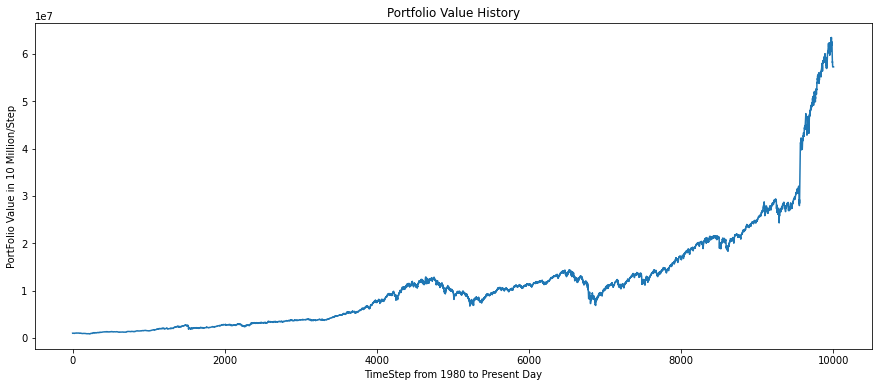

In [ ]:
plt.plot(investment_history)
plt.xlabel("TimeStep from 1980 to Present Day")
plt.ylabel("PortFolio Value in 10 Million/Step")
plt.title("Portfolio Value History")

# END